<a href="https://colab.research.google.com/github/Saltechy/forage-jpmc-swe-task-1/blob/main/UB22020743_Hussein_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fredapi


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
            Adj Close        MA7   Returns  Momentum       H_L      STD7  \
Date                                                                       
2012-01-18  26.670786  36.032857  0.046692  1.321133  2.150002  0.722166   
2012-01-19  26.955452  36.265714  0.010673  1.445219  0.440002  0.709151   
2012-01-20  27.269302  36.452857  0.011643  1.226233  0.780003  0.808615   
2012-01-23  27.488281  36.595714  0.008030  1.678789  0.669998  0.930464   
2012-01-24  27.488281  36.711429  0.000000  1.722582  1.090000  1.013976   
...               ...        ...       ...       ...       ...       ...   
2017-09-25  79.727974  93.865715 -0.007487  3.667900  1.430000  1.213285   
2017-09-26  79.372185  94.162857 -0.004463  2.380302  0.690002  0.730131   
2017-09-27  80.625900  94.485715 

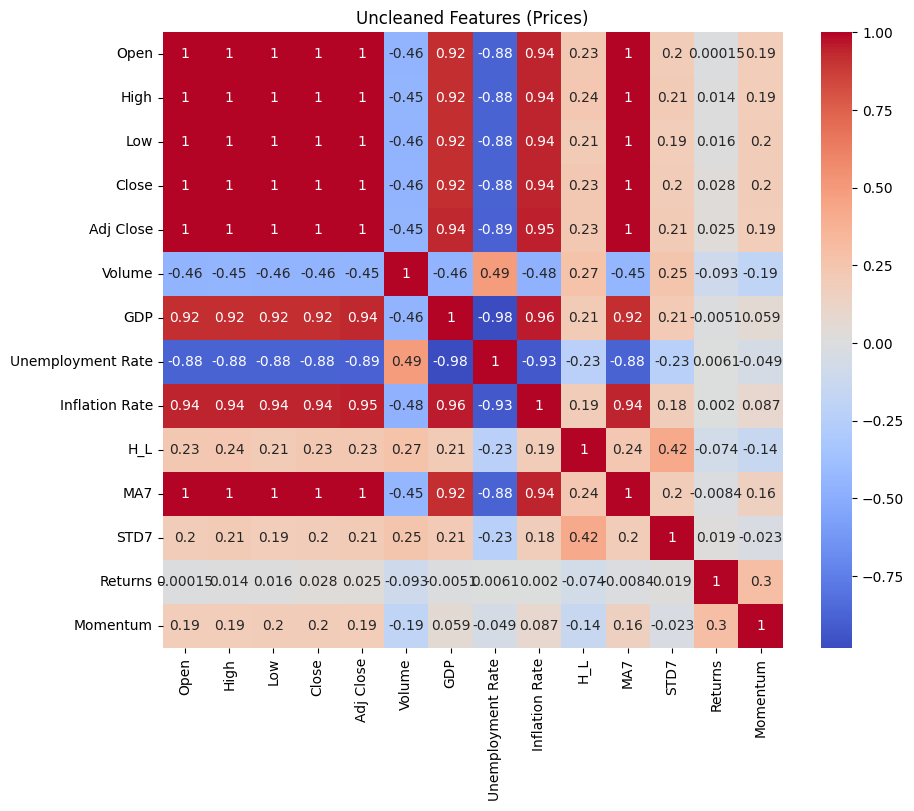

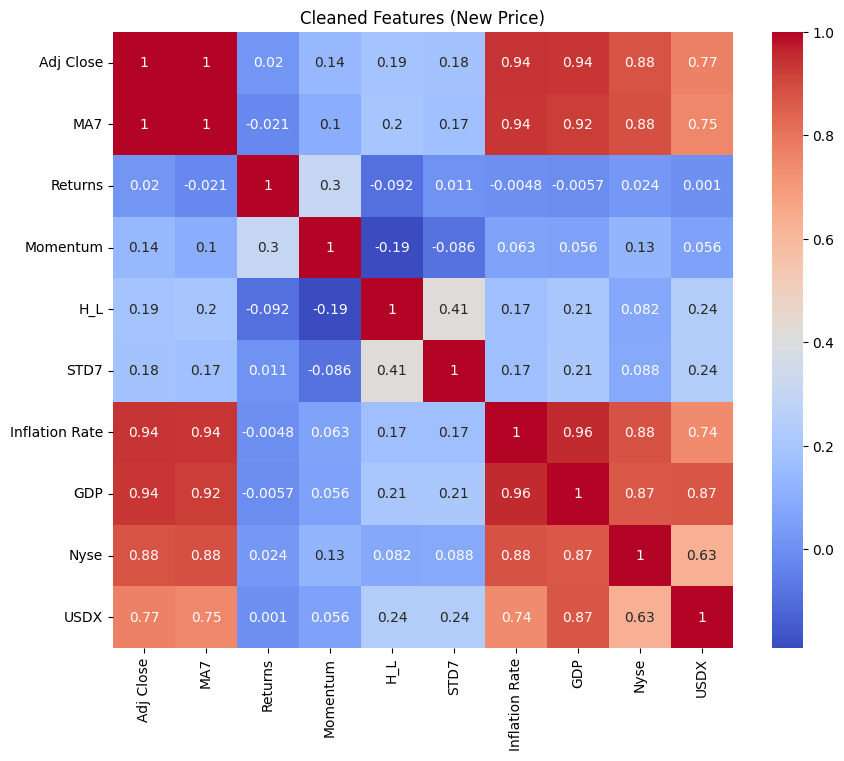

(986, 10)
(438, 10)
(986, 9)
(438, 9)
(986,)
(438,)


In [ ]:
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from fredapi import Fred
# Initialize the Fred object with your API key
fred = Fred(api_key='91f646410bb4ba0a3b12ace595673372')


# Download stock data from Yahoo Financ
# Set the ticker, start and end dates for the stock prices
ticker = 'BAC'
start = dt.datetime(2017, 1, 1)
end = dt.datetime(2022, 12, 31)

# Download the stock prices from Yahoo Finance And Drop Irrelevant Data

prices = yf.download(ticker, start, end, interval='1d')


# Define features related to Bank of America Corporation
# Download economic indicators from FRED API
fred = Fred(api_key='91f646410bb4ba0a3b12ace595673372')
gdp = pd.DataFrame(fred.get_series('GDP', start, end))
unemployment_rate = pd.DataFrame(fred.get_series('UNRATE', start, end))
inflation_rate = pd.DataFrame(fred.get_series('CPIAUCNS', start, end))

# Resample economic indicators to daily frequency
gdp_daily = gdp.resample('D').ffill()
unemployment_rate_daily = unemployment_rate.resample('D').ffill()
inflation_rate_daily = inflation_rate.resample('D').ffill()

#Merge with Prices Table
prices = prices.merge(gdp_daily, left_index=True, right_index=True, how='left').rename(columns={0: 'GDP'})
prices = prices.merge(unemployment_rate_daily, left_index=True, right_index=True, how='left').rename(columns={0: 'Unemployment Rate'})
prices = prices.merge(inflation_rate_daily, left_index=True, right_index=True, how='left').rename(columns={0: 'Inflation Rate'})

prices["H_L"] = prices.High - prices.Low
prices["MA7"] = prices['Close'].rolling(window=7).mean()
prices["STD7"]=prices['Close'].rolling(window=7).std()
prices['Returns'] = prices['Adj Close'].pct_change()
prices['Momentum'] = prices['Adj Close'] - prices['Adj Close'].shift(10)

new_price1=prices[['Adj Close', 'MA7', 'Returns','Momentum','H_L','STD7','Inflation Rate', 'GDP']]

# Add new Macro-Level Variabe (NYSE) To Account For Volatility Factor
nyse= yf.download('^NYA', start, end, interval='1d')['Adj Close']
nyse_c = nyse.rename('Nyse')
new_price2 = pd.merge(new_price1, nyse_c, left_index=True, right_index=True)

# Add USD/USDX Exchange Rate Data To Account For Being  Multinationl Comapny
usdx = yf.download('DX-Y.NYB', start, end, interval='1d')['Adj Close']
usdx = usdx.rename('USDX')
new_price = pd.merge(new_price2, usdx, left_index=True, right_index=True)

# Clean the Data
new_price =new_price.dropna()
print(new_price)
import matplotlib.pyplot as plt
import seaborn as sns

# Check The Presence Of Collinearity Within Features (Prices)
corr_prices = prices.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_prices, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Uncleaned Features (Prices)')

# Features without Multicollinearity (New Price)
corr_new_price = new_price.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_new_price, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Cleaned Features (New Price)')

plt.show()

# Split Data In To Tarinning And Test Sample
train_data=new_price.loc['2012-02-01':'2015-12-31']
test_data=new_price.loc['2016-01-01':'2017-12-31']
X_train = train_data.drop('Adj Close', axis=1)
X_test = test_data.drop('Adj Close', axis=1)
y_train = train_data['Adj Close']
y_test = test_data['Adj Close']

print (train_data.shape)
print (test_data.shape)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)



r2 score for model with selected features: 96.70258845329535
r2 score for model with all features: 96.77246402323267
MSE score for model with selected features: 4.50012224717472
MSE score for model with all features: 4.404759990339288
MAE for model with selected features: 1.9930475031214285
MAE for model with all features: 1.7059487559913422
RMSE for model with selected features: 2.1213491572993637
RMSE for model with all features: 2.0987520078225748


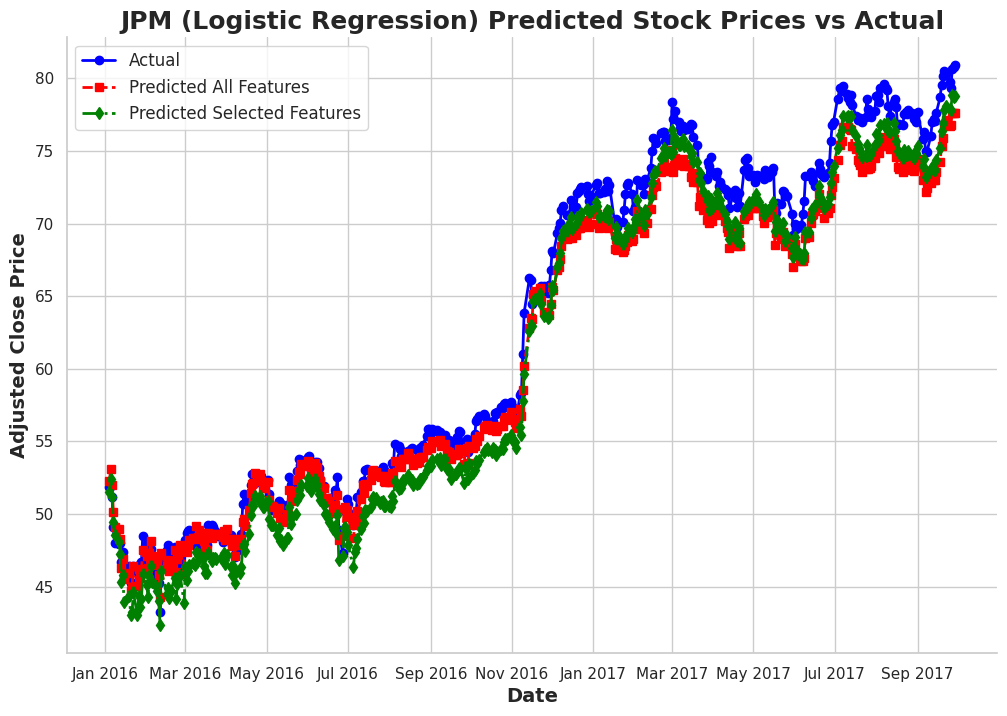

Selected features: Index(['MA7', 'Returns', 'Momentum', 'STD7'], dtype='object')


In [ ]:
# Create a linear regression model and fit it to the training data with all features
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
lr = LinearRegression()
lr.fit (X_train,y_train)
lr_y_pred_all = lr.predict(X_test)

# Calculate R2 and MSE scores for the model with all features
lr_r2_score_all = r2_score(y_test, lr_y_pred_all)
lr_mse_all = mean_squared_error(y_test, lr_y_pred_all)
lr_mae_all = mean_absolute_error(y_test, lr_y_pred_all)
lr_rmse_all = mean_squared_error(y_test, lr_y_pred_all, squared=False)

# Create an RFE object with a linear regression model selecting  features
selector = RFE(lr, n_features_to_select=4, step=1)
selector.fit(X_train, y_train)

# Fit the linear regression model to the training data with selected features
selected_features = selector.transform(X_train)
lr.fit(selected_features, y_train)
lr_y_pred_selected = lr.predict(selector.transform(X_test))

# Calculate MAE and RMSE scores for the model with selected features
lr_mae_selected = mean_absolute_error(y_test, lr_y_pred_selected)
lr_rmse_selected = mean_squared_error(y_test, lr_y_pred_selected, squared=False)
lr_r2_score_selected = r2_score(y_test, lr_y_pred_selected)
lr_mse_selected = mean_squared_error(y_test, lr_y_pred_selected)

# Compare the performance of the two models
print('r2 score for model with selected features:', lr_r2_score_selected*100)
print('r2 score for model with all features:', lr_r2_score_all*100)
print('MSE score for model with selected features:', lr_mse_selected)
print('MSE score for model with all features:', lr_mse_all)
print('MAE for model with selected features:', lr_mae_selected)
print('MAE for model with all features:', lr_mae_all)
print('RMSE for model with selected features:', lr_rmse_selected)
print('RMSE for model with all features:', lr_rmse_all)


# Set seaborn style for the plot
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(y_test.index, y_test.values, label='Actual', linewidth=2, color='blue', linestyle='-', marker='o', markersize=6)
ax.plot(y_test.index, lr_y_pred_all, label='Predicted All Features', linewidth=2, color='red', linestyle='--', marker='s', markersize=6)
ax.plot(y_test.index, lr_y_pred_selected, label='Predicted Selected Features', linewidth=2, color='green', linestyle='-.', marker='d', markersize=6)
# Set the title and axis labels
ax.set_title('JPM (Logistic Regression) Predicted Stock Prices vs Actual', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Adjusted Close Price', fontsize=14, fontweight='bold')
# Customize the x-axis date format
date_format = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(date_format)
# Add a legend and grid
ax.legend(fontsize=12)
ax.grid(True)
# Remove the top and right spines for a cleaner look
sns.despine(ax=ax, top=True, right=True)
plt.show()


# Get the column names of the selected features
selected_columns = X_train.columns[selector.support_]
print("Selected features:", selected_columns)


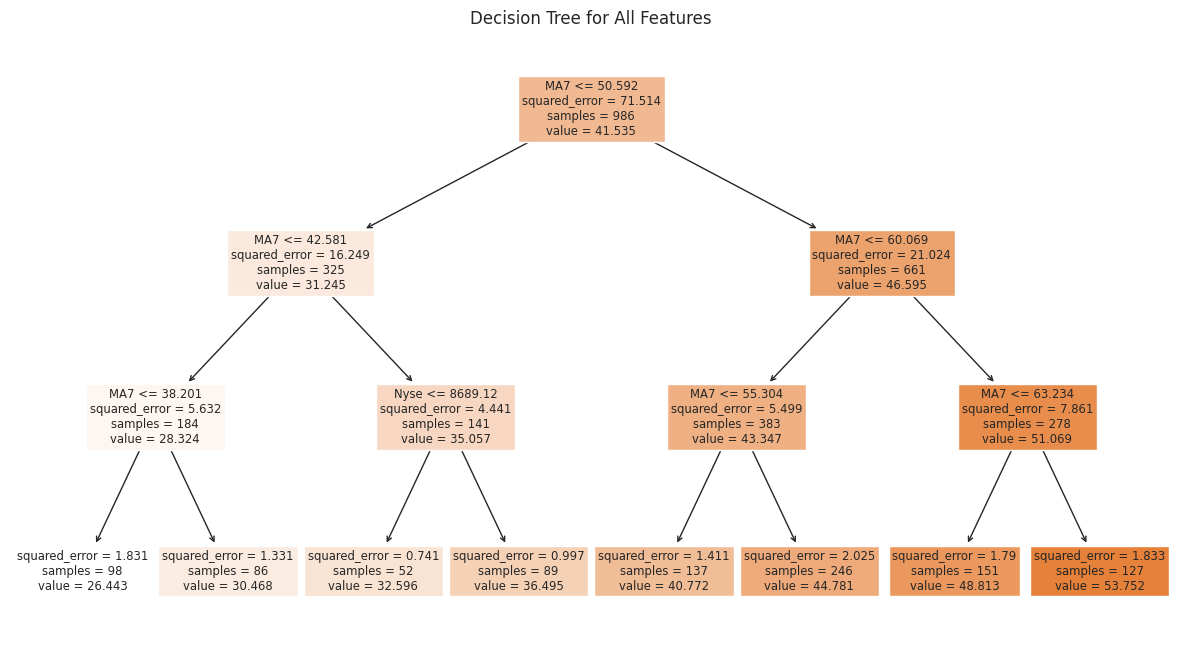

r2 score for model with selected features: -59.12511497694588
r2 score for model with all features: -59.12511497694588
MSE score for model with selected features: 217.16502773444313
MSE score for model with all features: 217.16502773444313
MAE for model with selected features: 11.314508067770264
MAE for model with all features: 11.314508067770264
RMSE for model with selected features: 14.736520204391644
RMSE for model with all features: 14.736520204391644


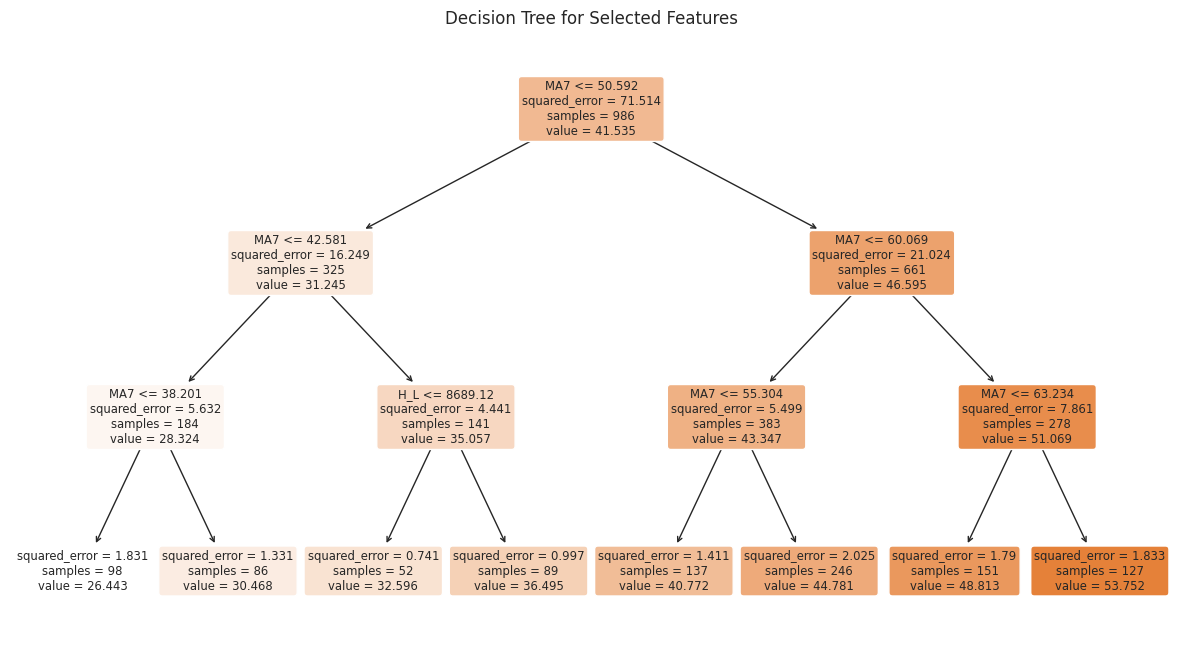

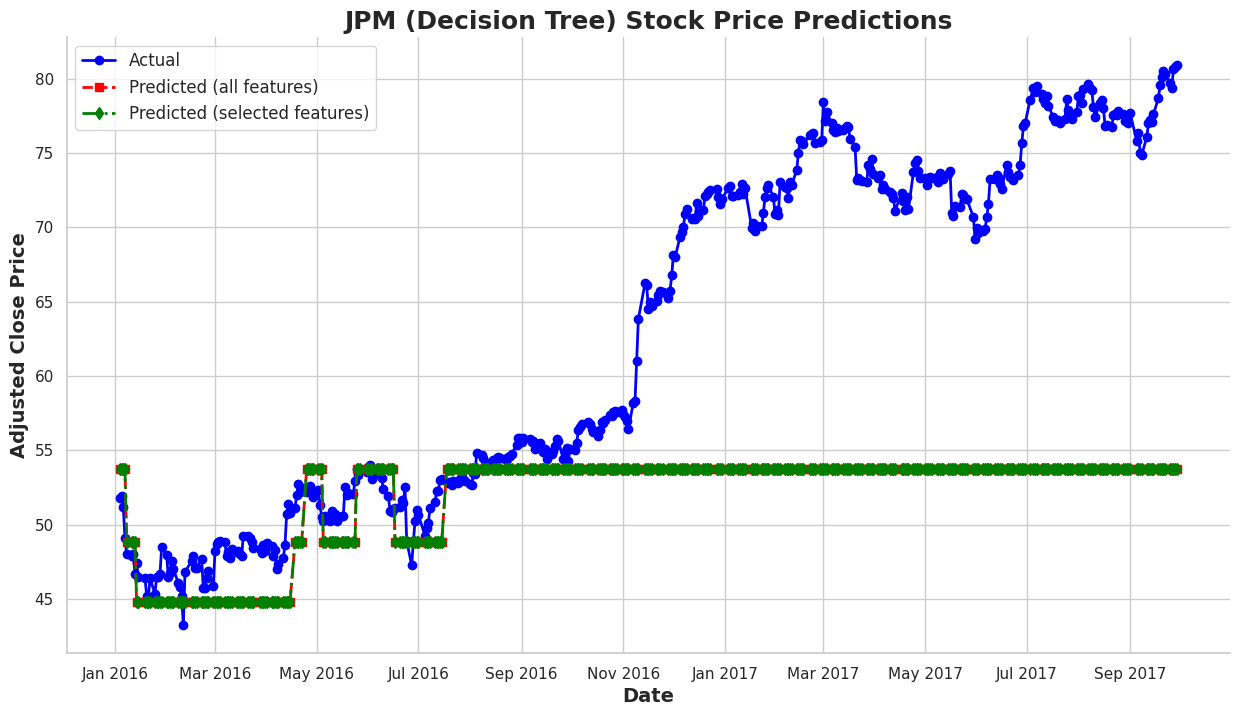

In [ ]:

from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.tree import export_graphviz
import graphviz

# Create a decision tree regressor
# Initialize a decision tree with default parameters


# Fit the model to the training data
dt = DecisionTreeRegressor(criterion='squared_error', max_depth=3, random_state=0)
dt.fit(X_train, y_train)

# Predict the target variable using the fitted DecisionTreeRegressor model
dt_y_pred = dt.predict(X_test)

# Two variables because function returns tuple of size 2
fig, ax = plt.subplots(figsize=(15, 8))
plot_tree(dt, filled=True, feature_names=X_train.columns, proportion=False)
plt.title('Decision Tree for All Features')
plt.show()

# Calculate R2, MAE and MSE scores for the model with all features
dt_r2_score = r2_score(y_test, dt_y_pred)
dt_mse = mean_squared_error(y_test, dt_y_pred)
dt_mae = mean_absolute_error(y_test, dt_y_pred)
dt_rmse = mean_squared_error(y_test, dt_y_pred, squared=False)


# Create an RFE object with a Decision Tree model selecting  features
selector = RFE(dt, n_features_to_select=5, step=1)
selector.fit(X_train, y_train)

# Fit the linear regression model to the training data with selected features
selected_features = selector.transform(X_train)
dt.fit(selected_features, y_train)
dt_y_pred_selected = dt.predict(selector.transform(X_test))

# Calculate MAE and RMSE scores for the model with selected features
dt_mae_selected = mean_absolute_error(y_test, dt_y_pred_selected)
dt_rmse_selected = mean_squared_error(y_test, dt_y_pred_selected, squared=False)
dt_r2_score_selected = r2_score(y_test, dt_y_pred_selected)
dt_mse_selected = mean_squared_error(y_test, dt_y_pred_selected)


# Compare the performance of the two models
print('r2 score for model with selected features:', dt_r2_score_selected*100)
print('r2 score for model with all features:', dt_r2_score*100)
print('MSE score for model with selected features:', dt_mse_selected)
print('MSE score for model with all features:', dt_mse)
print('MAE for model with selected features:', dt_mae_selected)
print('MAE for model with all features:', dt_mae)
print('RMSE for model with selected features:', dt_rmse_selected)
print('RMSE for model with all features:', dt_rmse)

# Visualize the decision tree
plt.figure(figsize=(15, 8))
plot_tree(dt, feature_names=X_train.columns, filled=True, rounded=True)
plt.title('Decision Tree for Selected Features')
plt.show()

# Set seaborn style for the plot
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(y_test.index, y_test, label="Actual", linewidth=2, color='blue', linestyle='-', marker='o', markersize=6)
ax.plot(y_test.index, dt_y_pred, label="Predicted (all features)", linewidth=2, color='red', linestyle='--', marker='s', markersize=6)
ax.plot(y_test.index, dt_y_pred_selected, label="Predicted (selected features)", linewidth=2, color='green', linestyle='-.', marker='d', markersize=6)
ax.set_title('JPM (Decision Tree) Stock Price Predictions', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Adjusted Close Price', fontsize=14, fontweight='bold')
date_format = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(date_format)
ax.legend(fontsize=12)
ax.grid(True)
sns.despine(ax=ax, top=True, right=True)

# Show the plot
plt.show()


Selected feature indices: [0 6 7]
Selected feature names: Index(['MA7', 'GDP', 'Nyse'], dtype='object')
All Features:
R2 Score: -0.4471171503710536
MSE: 197.494428293641
MAE: 10.74190033516383
RMSE: 14.053271088740905

Selected Features:
R2 Score: -0.2962872539794863
MSE: 176.9100104047342
MAE: 9.898649503106936
RMSE: 13.300752249581006


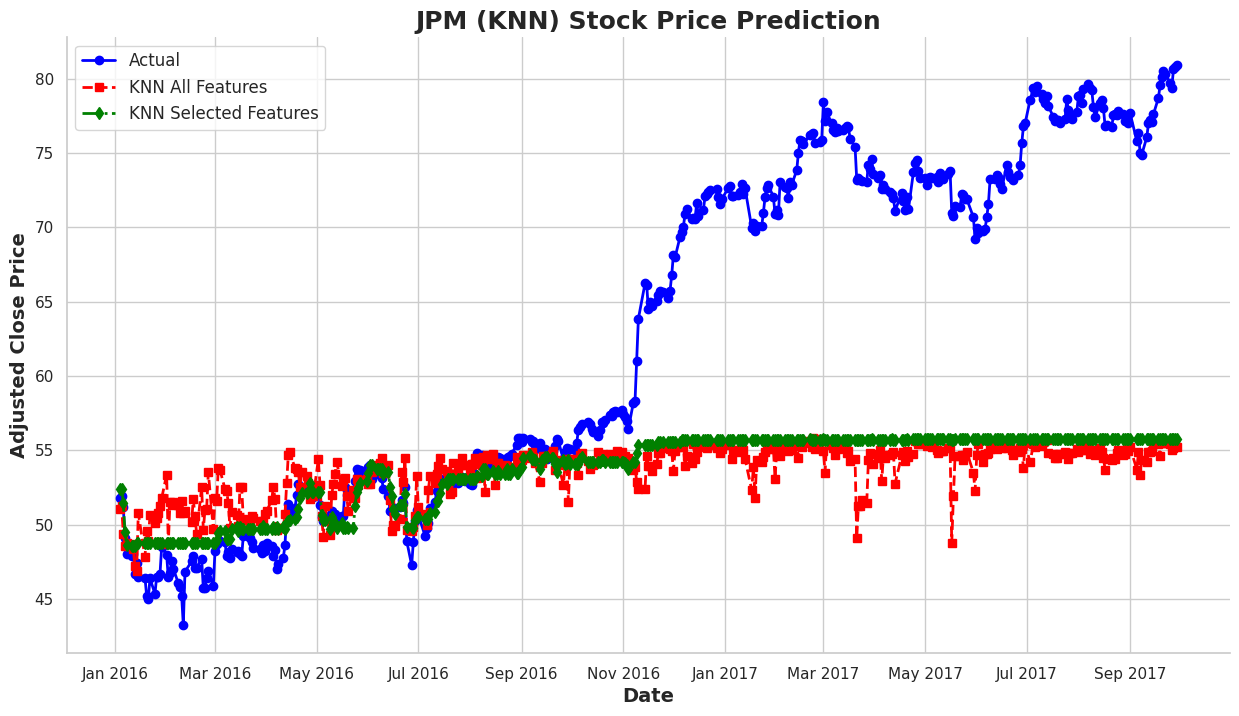

In [ ]:
# KNN algorithm from scikit-learn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import metrics

#Data Scalling / Normalisation (OPTIONAL)

sc = StandardScaler()
#scaling the training set
X_train_sc = sc.fit_transform(X_train)
#scaling the test set
X_test_sc = sc.transform(X_test)

# KNN regression
# training the algorithm
knn_reg = KNeighborsRegressor(n_neighbors = 5)
regressor = knn_reg.fit(X_train_sc,y_train)
# making prediction on test set
knn_y_pred = regressor.predict(X_test_sc)

knn_r2_score_all = r2_score(y_test, knn_y_pred)
knn_mse_all = mean_squared_error(y_test, knn_y_pred)
knn_mae_all = mean_absolute_error(y_test, knn_y_pred)
knn_rmse_all = mean_squared_error(y_test, knn_y_pred, squared=False)

# create a SelectKBest feature selector object with chi2 as the scoring function and select the top 2 features
selector = SelectKBest(score_func= f_regression, k=3)

# fit the selector to the scaled training data and transform the training set to include only the selected features
X_train_selected_knn = selector.fit_transform(X_train_sc, y_train)
X_test_selected_knn = selector.transform(X_test_sc)

# print the selected feature indices and names
print("Selected feature indices:", selector.get_support(indices=True))
print("Selected feature names:", X_train.columns[selector.get_support()])

# train and evaluate the KNN classifier on the selected features
knn_reg.fit(X_train_selected_knn, y_train)
knn_y_pred_sl = knn_reg.predict(X_test_selected_knn)


knn_r2_score_selected = r2_score(y_test, knn_y_pred_sl)
knn_mse_selected = mean_squared_error(y_test, knn_y_pred_sl)
knn_mae_selected = mean_absolute_error(y_test, knn_y_pred_sl)
knn_rmse_selected = mean_squared_error(y_test, knn_y_pred_sl, squared=False)


# Display evaluation metrics
print("All Features:")
print("R2 Score:", knn_r2_score_all)
print("MSE:", knn_mse_all)
print("MAE:", knn_mae_all)
print("RMSE:", knn_rmse_all)
print("\nSelected Features:")
print("R2 Score:", knn_r2_score_selected)
print("MSE:", knn_mse_selected)
print("MAE:", knn_mae_selected)
print("RMSE:", knn_rmse_selected)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Set seaborn style for the plot
sns.set(style="whitegrid")

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(15, 8))
# Plot the actual and predicted stock prices for the test data
ax.plot(y_test.index, y_test, label="Actual", linewidth=2, color='blue', linestyle='-', marker='o', markersize=6)
ax.plot(y_test.index, knn_y_pred, label="KNN All Features", linewidth=2, color='red', linestyle='--', marker='s', markersize=6)
ax.plot(y_test.index, knn_y_pred_sl, label="KNN Selected Features", linewidth=2, color='green', linestyle='-.', marker='d', markersize=6)
ax.set_title(f'{ticker} (KNN) Stock Price Prediction', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Adjusted Close Price', fontsize=14, fontweight='bold')
date_format = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(date_format)
ax.legend(fontsize=12)
ax.grid(True)
sns.despine(ax=ax, top=True, right=True)

# Show the plot
plt.show()



r2 score for model with selected features: -34.70757565370026
r2 score for model with all features: -38.13555367303623
MSE score for model with selected features: 183.84134023792356
MSE score for model with all features: 188.51965228030613
MAE for model with selected features: 10.316074457560498
MAE for model with all features: 10.430528714863676
RMSE for model with selected features: 13.55881042857092
RMSE for model with all features: 13.730245892929453


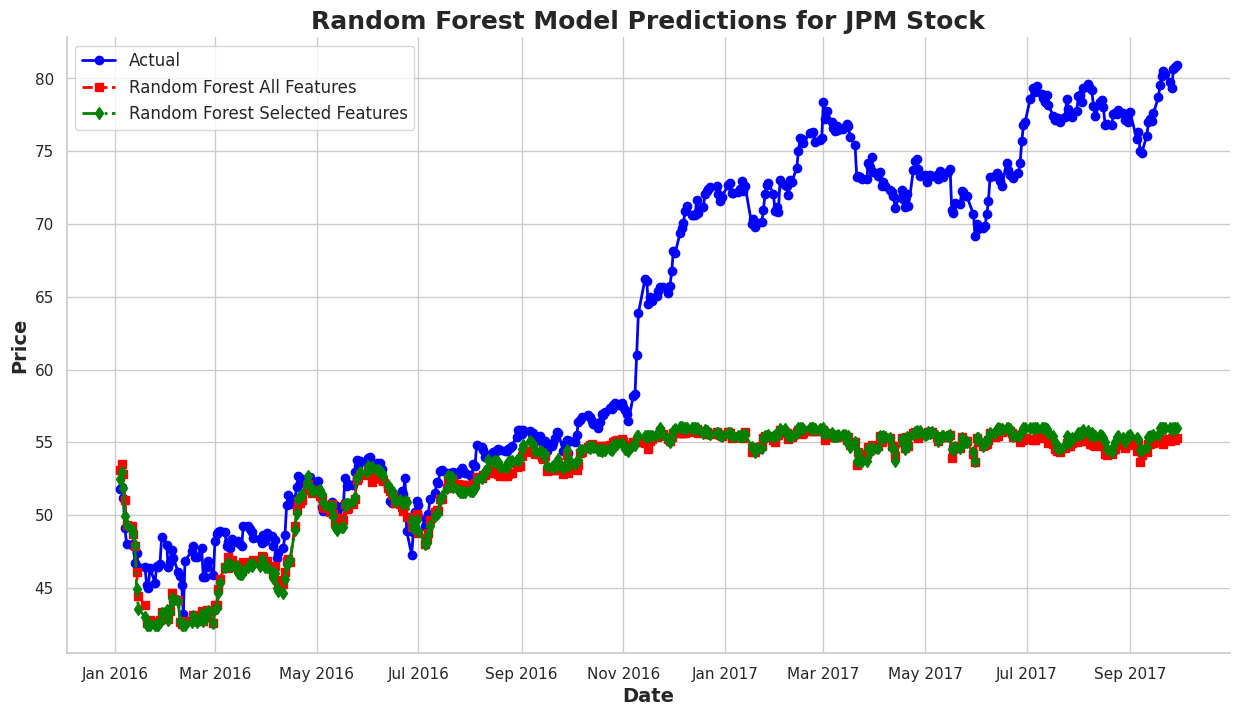

                                 R2 Score         MSE        MAE       RMSE
Model                                                                      
Random Forest All Features      -0.381356  188.519652  10.430529  13.730246
Random Forest Selected Features -0.347076  183.841340  10.316074  13.558810


In [ ]:
#RANDOM fOREST
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model with 100 trees
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
rf_y_pred = rf.predict(X_test)

# Calculate R2 and MSE scores for the model with all features
rf_r2_score_all = r2_score(y_test, rf_y_pred)
rf_mse_all = mean_squared_error(y_test, rf_y_pred)
rf_mae_all = mean_absolute_error(y_test, rf_y_pred)
rf_rmse_all = mean_squared_error(y_test, rf_y_pred, squared=False)


# Create an RFE object model to select  features
selector = RFE(rf, n_features_to_select=4, step=1)
selector.fit(X_train, y_train)

# Fit the linear regression model to the training data with selected features
selected_features = selector.transform(X_train)
rf.fit(selected_features, y_train)
rf_y_pred_sl = rf.predict(selector.transform(X_test))

# Calculate MAE and RMSE scores for the model with selected features
rf_mae_selected = mean_absolute_error(y_test, rf_y_pred_sl)
rf_rmse_selected = mean_squared_error(y_test, rf_y_pred_sl, squared=False)
rf_r2_score_selected = r2_score(y_test, rf_y_pred_sl)
rf_mse_selected = mean_squared_error(y_test, rf_y_pred_sl)

# Compare the performance of the two models
print('r2 score for model with selected features:', rf_r2_score_selected*100)
print('r2 score for model with all features:', rf_r2_score_all*100)
print('MSE score for model with selected features:', rf_mse_selected)
print('MSE score for model with all features:', rf_mse_all)
print('MAE for model with selected features:',rf_mae_selected)
print('MAE for model with all features:', rf_mae_all)
print('RMSE for model with selected features:', rf_rmse_selected)
print('RMSE for model with all features:', rf_rmse_all)

# Set seaborn style for the plot
sns.set(style="whitegrid")
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(15, 8))
# Plot the actual and predicted stock prices for the test data
ax.plot(y_test.index, y_test, label="Actual", linewidth=2, color='blue', linestyle='-', marker='o', markersize=6)
ax.plot(y_test.index, rf_y_pred, label="Random Forest All Features", linewidth=2, color='red', linestyle='--', marker='s', markersize=6)
ax.plot(y_test.index, rf_y_pred_sl, label="Random Forest Selected Features", linewidth=2, color='green', linestyle='-.', marker='d', markersize=6)
ax.set_title('Random Forest Model Predictions for JPM Stock', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Price', fontsize=14, fontweight='bold')
date_format = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(date_format)
# Add a legend and grid
ax.legend(fontsize=12)
ax.grid(True)
sns.despine(ax=ax, top=True, right=True)
# Show the plot
plt.show()
# Visualize the evaluation metrics in a table
metrics_data = {
    "Model": ["Random Forest All Features", "Random Forest Selected Features"],
    "R2 Score": [rf_r2_score_all, rf_r2_score_selected],
    "MSE": [rf_mse_all, rf_mse_selected],
    "MAE": [rf_mae_all, rf_mae_selected],
    "RMSE": [rf_rmse_all, rf_rmse_selected]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df.set_index("Model", inplace=True)
print(metrics_df)



<ipython-input-10-61f7a300b2c4>:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasRegressor(build_fn=create_model, epochs=50, batch_size=32, verbose=2)


Epoch 1/50
25/25 - 3s - loss: 1781.0245 - 3s/epoch - 121ms/step
Epoch 2/50
25/25 - 0s - loss: 1688.3999 - 151ms/epoch - 6ms/step
Epoch 3/50
25/25 - 0s - loss: 1525.2906 - 157ms/epoch - 6ms/step
Epoch 4/50
25/25 - 0s - loss: 1221.3102 - 207ms/epoch - 8ms/step
Epoch 5/50
25/25 - 0s - loss: 776.8200 - 193ms/epoch - 8ms/step
Epoch 6/50
25/25 - 0s - loss: 370.9142 - 193ms/epoch - 8ms/step
Epoch 7/50
25/25 - 0s - loss: 194.0773 - 136ms/epoch - 5ms/step
Epoch 8/50
25/25 - 0s - loss: 144.4192 - 96ms/epoch - 4ms/step
Epoch 9/50
25/25 - 0s - loss: 113.2951 - 70ms/epoch - 3ms/step
Epoch 10/50
25/25 - 0s - loss: 91.1157 - 99ms/epoch - 4ms/step
Epoch 11/50
25/25 - 0s - loss: 76.4103 - 70ms/epoch - 3ms/step
Epoch 12/50
25/25 - 0s - loss: 65.5734 - 105ms/epoch - 4ms/step
Epoch 13/50
25/25 - 0s - loss: 58.3406 - 85ms/epoch - 3ms/step
Epoch 14/50
25/25 - 0s - loss: 52.3401 - 106ms/epoch - 4ms/step
Epoch 15/50
25/25 - 0s - loss: 47.9116 - 77ms/epoch - 3ms/step
Epoch 16/50
25/25 - 0s - loss: 43.9286 - 83

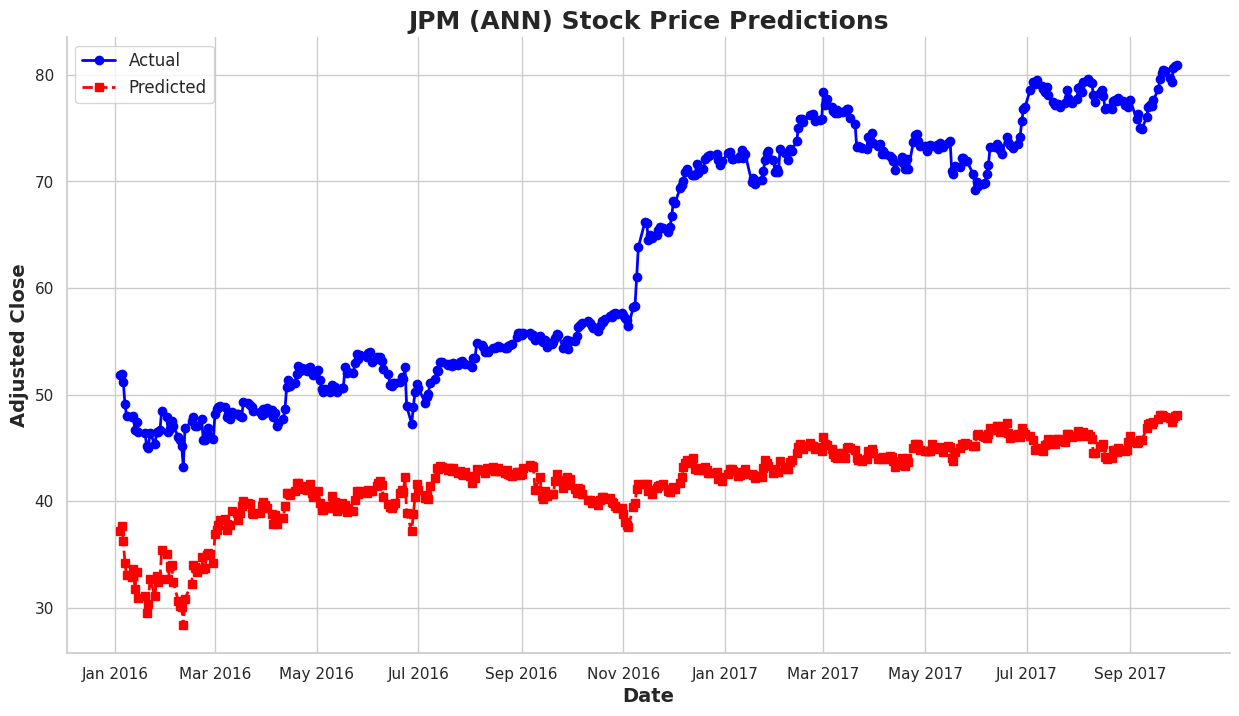

In [ ]:
#ANN Standardize the data
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


scaler_ann = StandardScaler()
X_train_ann = scaler_ann.fit_transform(X_train)
X_test_ann = scaler_ann.transform(X_test)

# Define the function to create the Keras model
def create_model():
    # Build the neural network model
    model_ann = Sequential()
    model_ann.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
    model_ann.add(Dense(32, activation='relu'))
    model_ann.add(Dense(1))

    # Compile the model
    model_ann.compile(loss='mean_squared_error', optimizer='adam')

    return model_ann


# Wrap the Keras model in a scikit-learn wrapper
model_ann = KerasRegressor(build_fn=create_model, epochs=50, batch_size=32, verbose=2)
# Evaluate the model using cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_ann, X_train_ann, y_train, scoring='neg_mean_squared_error', cv=cv)

# Train the model on the entire training set
model_ann.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)
# Evaluate the model on the test data
y_pred_ann = model_ann.predict(X_test)
mse_ann_test = mean_squared_error(y_test, y_pred_ann)
r2_score_ann_test = r2_score(y_test, y_pred_ann)


# Calculate the MAE,R2, MSE and RMSE
mse_ann = -1 * scores.mean()
r2_score_ann = 1 - mse_ann / y_test.var()
mae_ann_test = mean_absolute_error(y_test, y_pred_ann)
rmse_ann_test = np.sqrt(mse_ann_test)

#Evaluation Metrics

# Print the scores
print('R-squared score:', r2_score_ann)
print('MSE:', mse_ann)
print('MAE (test):', mae_ann_test)
print('RMSE (test):', rmse_ann_test)





# Set seaborn style for the plot
sns.set(style="whitegrid")

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(15, 8))
# Plot the actual and predicted stock prices for the test data
ax.plot(y_test.index, y_test, label="Actual", linewidth=2, color='blue', linestyle='-', marker='o', markersize=6)
ax.plot(y_test.index, y_pred_ann, label="Predicted", linewidth=2, color='red', linestyle='--', marker='s', markersize=6)
# Set the title and axis labels
ax.set_title(f'{ticker} (ANN) Stock Price Predictions', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Adjusted Close', fontsize=14, fontweight='bold')
# Customize the x-axis date format
date_format = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(date_format)
# Add a legend and grid
ax.legend(fontsize=12)
ax.grid(True)
# Remove the top and right spines for a cleaner look
sns.despine(ax=ax, top=True, right=True)
# Show the plot
plt.show()



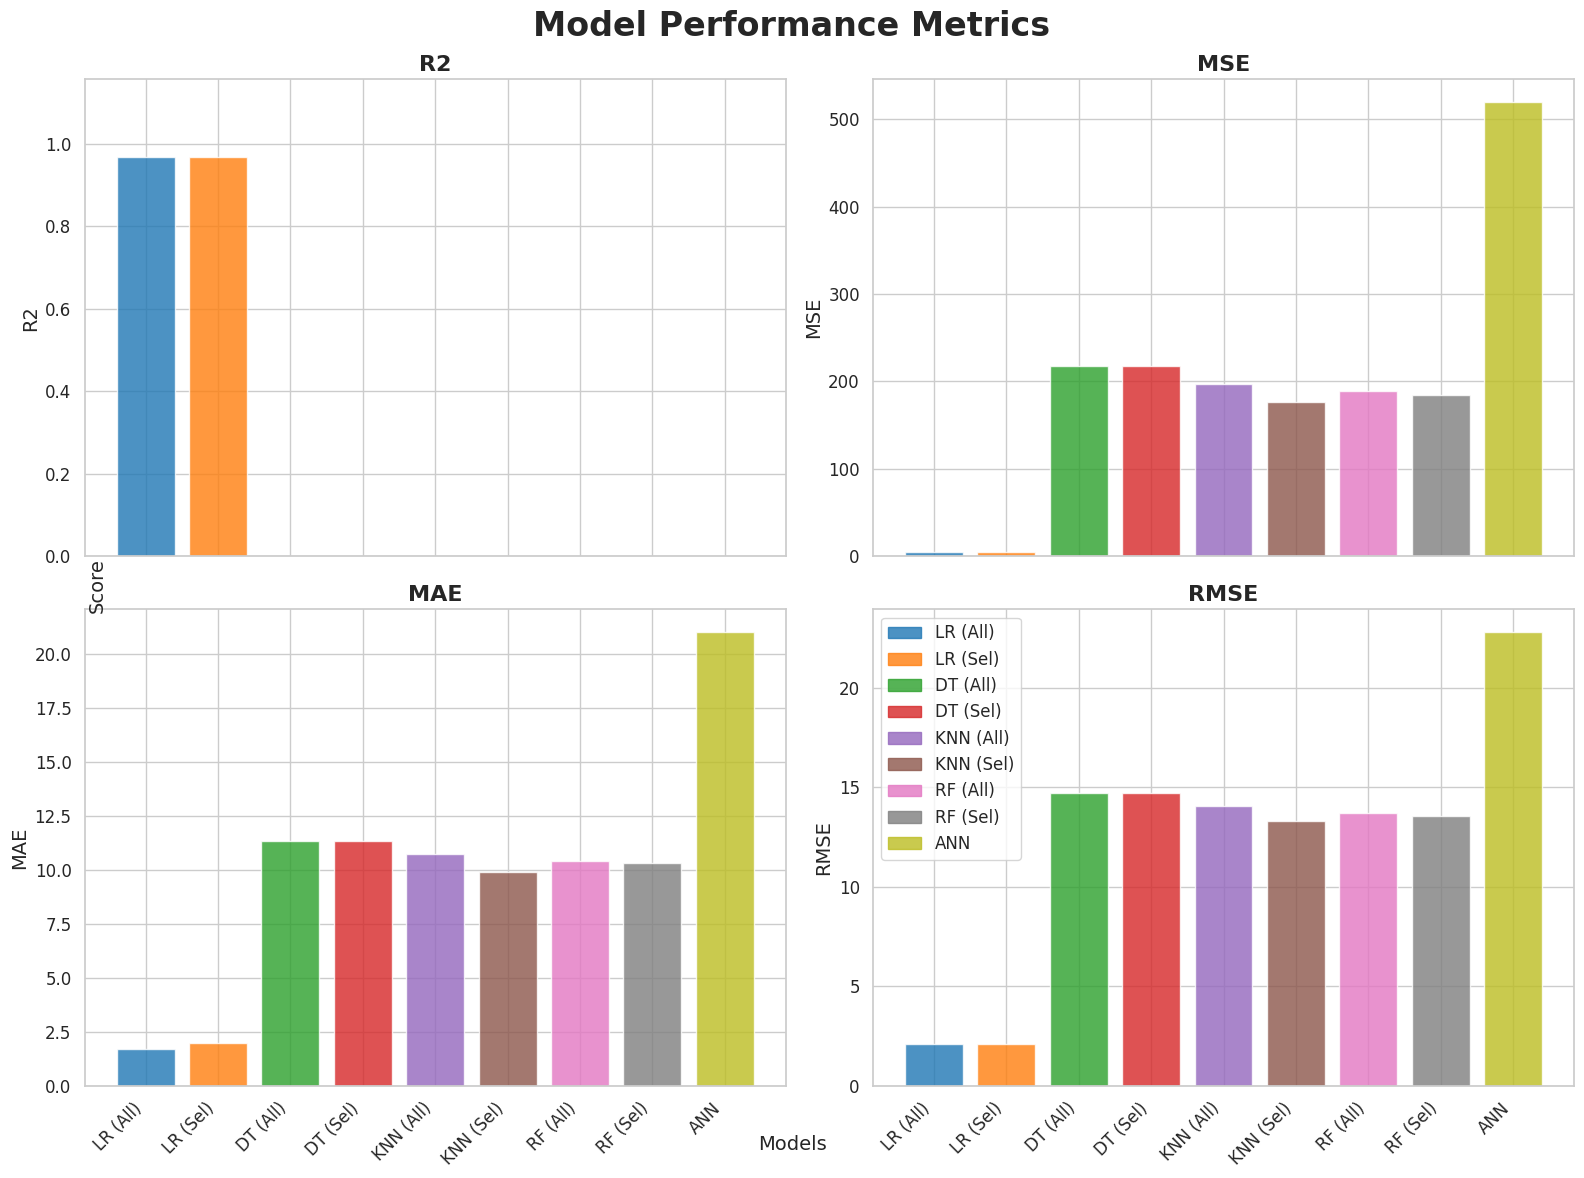

In [ ]:
#VISUALIZING THE EVALUATION METRICS  FOR ALL THE MODELS

# Define the metrics and models
metrics = ['R2', 'MSE', 'MAE', 'RMSE']
models = ['LR (All)', 'LR (Sel)', 'DT (All)', 'DT (Sel)', 'KNN (All)', 'KNN (Sel)', 'RF (All)', 'RF (Sel)', 'ANN']

# Define the scores for each model and metric
r2_scores = [lr_r2_score_all, lr_r2_score_selected, dt_r2_score, dt_r2_score_selected, knn_r2_score_all, knn_r2_score_selected, rf_r2_score_all, rf_r2_score_selected, r2_score_ann_test]
mse_scores = [lr_mse_all, lr_mse_selected, dt_mse, dt_mse_selected, knn_mse_all, knn_mse_selected, rf_mse_all, rf_mse_selected, mse_ann_test]
mae_scores = [lr_mae_all, lr_mae_selected, dt_mae, dt_mae_selected, knn_mae_all, knn_mae_selected, rf_mae_all, rf_mae_selected, mae_ann_test]
rmse_scores = [lr_rmse_all, lr_rmse_selected, dt_rmse, dt_rmse_selected, knn_rmse_all, knn_rmse_selected, rf_rmse_all, rf_rmse_selected, rmse_ann_test]

# Create a figure with subplots for each metric
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharex=True)

# Add a title to the figure
fig.suptitle('Model Performance Metrics', fontsize=24, fontweight='bold')

# Set the color palette
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']

# Plot each metric
for i, metric in enumerate(metrics):
    # Determine the subplot coordinates
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    # Add a title to the subplot
    ax.set_title(metric, fontsize=16, fontweight='bold')

    # Plot a bar for each model
    for j, model in enumerate(models):
        score = [r2_scores[j], mse_scores[j], mae_scores[j], rmse_scores[j]][i]
        ax.bar(j, score, color=colors[j], alpha=0.8)

    # Add labels and limits to the subplot
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=12)
    ax.set_ylabel(metric, fontsize=14)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis='both', labelsize=12)

# Create a legend for the models
handles = [plt.Rectangle((0,0),1,1, color=colors[i], alpha=0.8) for i in range(len(models))]
axs[1, 1].legend(handles, models, fontsize=12)

# Add a common x-axis label
fig.text(0.5, 0.03, 'Models', ha='center', fontsize=14)

# Add a common y-axis label
fig.text(0.06, 0.5, 'Score', va='center', rotation='vertical', fontsize=14)

# Adjust subplot spacing
fig.tight_layout()

# Save the figure as a PNG file
plt.savefig('model_performance.png')

# Show the figure
plt.show()


TASK 2

In [ ]:
#UP & DOWN (CLASSIFICATION) STOCK PREDICTION -JP MORGAN(2012-2017)

# Create new feature
prices['Target'] = np.where(prices['Adj Close'].pct_change() > 0, 1, 0)

# Add the new feature to the dataset
new_price['Target'] = prices['Target']
new_price = new_price.dropna()

# Split Data Into Training And Test Sample
train_data_c = new_price.loc['2012-02-01':'2015-12-31']
test_data_c = new_price.loc['2016-01-01':'2017-12-31']
X_train_c = train_data_c.drop(['Target', 'Adj Close'], axis=1)
X_test_c = test_data_c.drop(['Target', 'Adj Close'], axis=1)
cy_train = train_data_c['Target']
cy_test = test_data_c['Target']

In [ ]:
!pip install --upgrade mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
# train a logistic classification model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# train a logistic classification model
lra = LogisticRegression()
lra.fit(X_train_c, cy_train)
# Predict the target values for the test dataset
y_pred_lra = lra.predict(X_test_c)
print(metrics.classification_report(cy_test,y_pred_lra))

# Create a RFE object with the estimator and desired number of features to select
estimator = LogisticRegression(max_iter=10000)
selector = RFE(estimator,n_features_to_select=4,step=1)
# Fit the selector to the training data and transform the training set to include only the selected features
selector.fit(X_train_c,cy_train)
X_train_selected_lr = selector.transform(X_train_c)
X_test_selected_lr = selector.transform(X_test_c)

# Print the selected feature indices and names
print("Selected RFE feature indices:", selector.get_support(indices=True))
# The get_support method of the selector object returns a boolean mask indicating which features were selected, and the indices parameter is set to True to return the indices of the selected features.
print("Selected RFE feature names:", X_train_c.columns[selector.get_support()])

# Predict on the test set and calculate accuracy for the model with all features
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_selected_lr,cy_train)
y_pred_lr = lr.predict(X_test_selected_lr)
print(metrics.classification_report(cy_test,y_pred_lr))

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Define stepwise logistic regression
sfs = SFS(lr,k_features=4,forward=True,floating=False,scoring='accuracy')
sfs.fit(X_train_c,cy_train)

print('selected SFS feature names', sfs.k_feature_names_)

# Transform the training and test data using the selected features
X_train_selected_lrs = sfs.transform(X_train_c)
X_test_selected_lrs = sfs.transform(X_test_c)

# Develop model using selected features
lrs = LogisticRegression(max_iter=10000)
lrs.fit(X_train_selected_lrs,cy_train)
y_pred_lrs = lrs.predict(X_test_selected_lrs)
print(metrics.classification_report(cy_test,y_pred_lrs))


              precision    recall  f1-score   support

           0       0.51      0.89      0.65       211
           1       0.66      0.20      0.31       227

    accuracy                           0.53       438
   macro avg       0.58      0.54      0.48       438
weighted avg       0.59      0.53      0.47       438

Selected RFE feature indices: [1 2 3 4]
Selected RFE feature names: Index(['Returns', 'Momentum', 'H_L', 'STD7'], dtype='object')
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       211
           1       0.62      0.67      0.65       227

    accuracy                           0.62       438
   macro avg       0.62      0.62      0.62       438
weighted avg       0.62      0.62      0.62       438

selected SFS feature names ('Returns', 'Momentum', 'H_L', 'STD7')
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       211
           1       0.62      0.67      0.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsClassifier

# create KNN classifier objects
knn_all = KNeighborsClassifier(n_neighbors=10)  # for all features
knn = KNeighborsClassifier(n_neighbors=10)  # for selected features

# create a standadscale object and scale the training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_c)
X_test_scaled = scaler.transform(X_test_c)

print (X_train_scaled.shape)
print (X_test_scaled.shape)
print (cy_train.shape)
print(cy_test.shape)

#Fit for all Variables
knn_all.fit(X_train_scaled, cy_train)
y_pred_knna = knn_all.predict(X_test_scaled)
print(metrics.classification_report(cy_test, y_pred_knna))

# create a SelectKBest feature selector object with chi2 as the scoring function and select the top 4 features
selector = SelectKBest(score_func= f_regression, k=4)
# fit the selector to the scaled training data and transform the training set to include only the selected features
X_train_selected_knn = selector.fit_transform(X_train_scaled, cy_train)
X_test_selected_knn = selector.transform(X_test_scaled)

# print the selected feature indices and names
print("Selected KNN feature indices:", selector.get_support(indices=True))
print("Selected KNN feature names:", X_train.columns[selector.get_support()])

# train and evaluate the KNN classifier on the selected features
knn.fit(X_train_selected_knn, cy_train)
y_pred_knn = knn.predict(X_test_selected_knn)
print(metrics.classification_report(cy_test, y_pred_knn))





(986, 9)
(438, 9)
(986,)
(438,)
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       211
           1       0.89      0.84      0.87       227

    accuracy                           0.87       438
   macro avg       0.87      0.87      0.87       438
weighted avg       0.87      0.87      0.87       438

Selected KNN feature indices: [1 2 3 7]
Selected KNN feature names: Index(['Returns', 'Momentum', 'H_L', 'Nyse'], dtype='object')
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       211
           1       0.94      0.93      0.93       227

    accuracy                           0.93       438
   macro avg       0.93      0.93      0.93       438
weighted avg       0.93      0.93      0.93       438



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       211
           1       1.00      1.00      1.00       227

    accuracy                           1.00       438
   macro avg       1.00      1.00      1.00       438
weighted avg       1.00      1.00      1.00       438

Confusion Matrix:
 [[211   0]
 [  0 227]]
AUC Score: 1.0


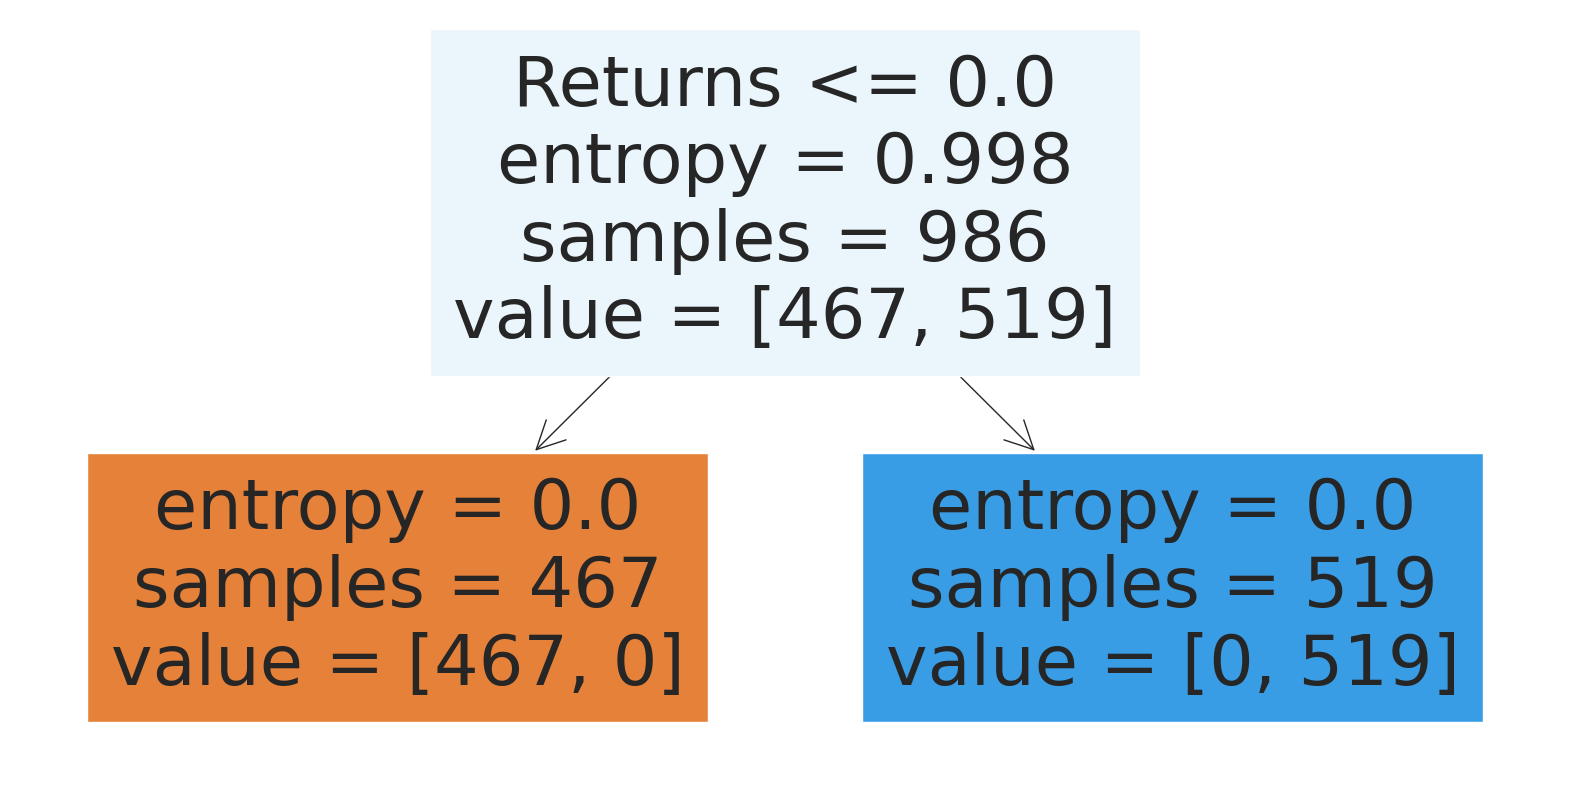

Shape of X_train_c: (986, 9)
Shape of X_test_c: (438, 9)
Columns in the dataset: Index(['MA7', 'Returns', 'Momentum', 'H_L', 'STD7', 'Inflation Rate', 'GDP',
       'Nyse', 'USDX'],
      dtype='object')


In [ ]:
# Import required libraries
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text
from IPython.display import Image
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.metrics import roc_curve, auc,roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'criterion': ['entropy'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [10, 50, 100, 200],
    'min_samples_leaf': [10, 50, 100, 200],
    'random_state': [0]
}

# Initialize the decision tree classifier
dtc = DecisionTreeClassifier()

# Perform the grid search with cross-validation
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_c, cy_train)

# Use the best estimator from the grid search to make predictions
best_dtc = grid_search.best_estimator_
y_pred_dtc = best_dtc.predict(X_test_c)

# Evaluate the model
print("Classification Report:\n", classification_report(cy_test, y_pred_dtc))
print("Confusion Matrix:\n", confusion_matrix(cy_test, y_pred_dtc))
print("AUC Score:", roc_auc_score(cy_test, y_pred_dtc))
fpr, tpr, thresholds = roc_curve(cy_test, y_pred_dtc)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_dtc, feature_names=X_train.columns, filled=True)
plt.show()

print("Shape of X_train_c:", X_train_c.shape)
print("Shape of X_test_c:", X_test_c.shape)
print("Columns in the dataset:", X_train_c.columns)


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       211
           1       1.00      1.00      1.00       227

    accuracy                           1.00       438
   macro avg       1.00      1.00      1.00       438
weighted avg       1.00      1.00      1.00       438



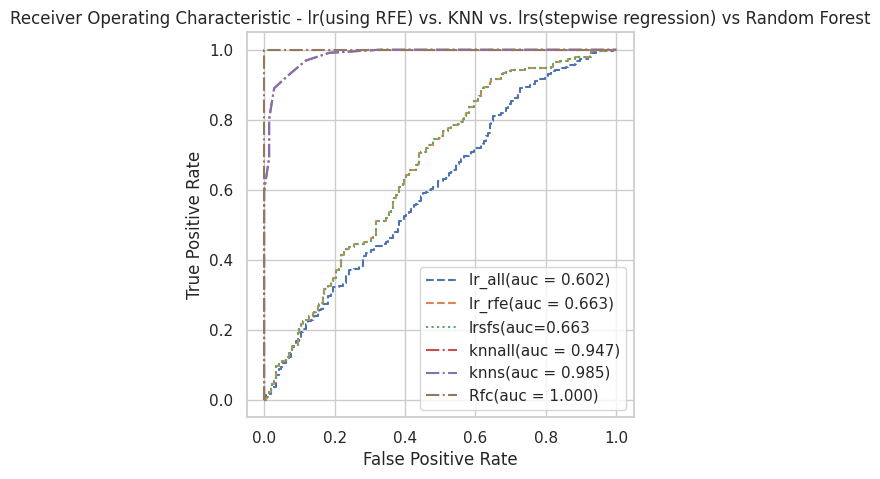

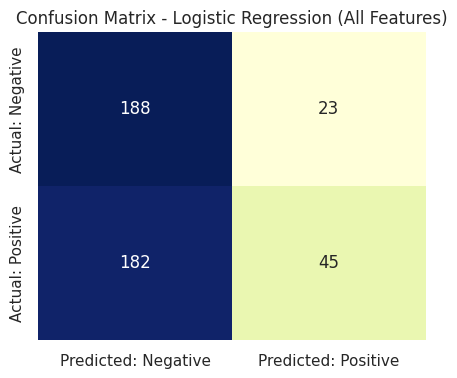

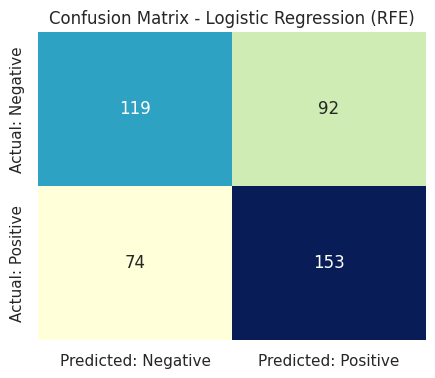

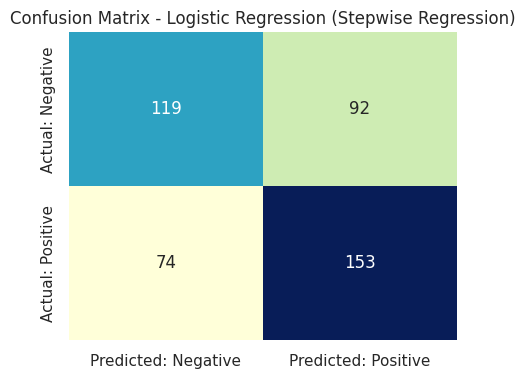

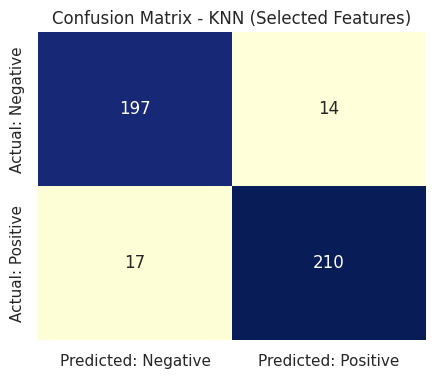

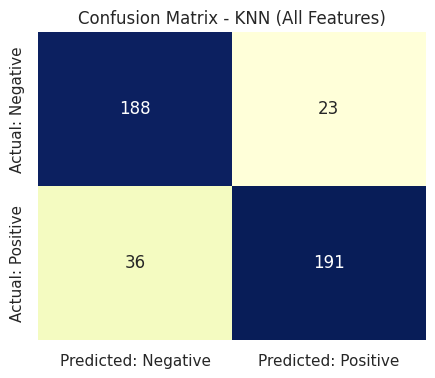

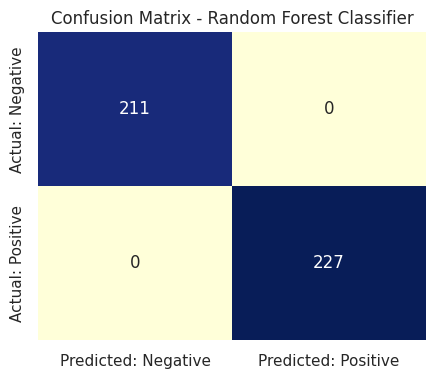

Classification Report - Logistic Regression (All Features):
               precision    recall  f1-score   support

           0       0.51      0.89      0.65       211
           1       0.66      0.20      0.31       227

    accuracy                           0.53       438
   macro avg       0.58      0.54      0.48       438
weighted avg       0.59      0.53      0.47       438

Classification Report - Logistic Regression (RFE):
               precision    recall  f1-score   support

           0       0.62      0.56      0.59       211
           1       0.62      0.67      0.65       227

    accuracy                           0.62       438
   macro avg       0.62      0.62      0.62       438
weighted avg       0.62      0.62      0.62       438

Classification Report - Logistic Regression (Stepwise Regression):
               precision    recall  f1-score   support

           0       0.62      0.56      0.59       211
           1       0.62      0.67      0.65       227

 

In [ ]:
# MOdel: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

# Train a Random Forest Classifier model
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rfc.fit(X_train_c, cy_train)
# Predict the target values for the test dataset
y_pred_rfc = rfc.predict(X_test_c)

# Calculate the accuracy of the model
accuracy_rfc=accuracy_score(cy_test, y_pred_rfc)
print("Accuracy:", accuracy_rfc)

# Evaluate the model
print(metrics.classification_report(cy_test, y_pred_rfc))

# Checking ROC
from sklearn.metrics import roc_curve, roc_auc_score, auc
y_prob_lra = lra.predict_proba(X_test_c)[:,1]
y_prob_lr = lr.predict_proba(X_test_selected_lr)[:,1]
y_prob_lrs = lrs.predict_proba(X_test_selected_lrs)[:,1]
y_prob_knn = knn.predict_proba(X_test_selected_knn)[:,1]
y_prob_knna = knn_all.predict_proba(X_test_scaled)[:,1]
y_prob_rfc = rfc.predict_proba(X_test_c)[:,1]

# ROC plotting code
fprlra, tprlra, thresholdlra = roc_curve(cy_test, y_prob_lra)
auc_lra = auc(fprlra, tprlra)

fprlr, tprlr, thresholdlr = roc_curve(cy_test, y_prob_lr)
auc_lr = auc(fprlr, tprlr)

fprlrs,tprlrs,thresholdlrs = roc_curve(cy_test,y_prob_lrs)
auc_lrs = auc(fprlrs,tprlrs)
fprknna, tprknna, thresholdknna = roc_curve(cy_test, y_prob_knna)
auc_knna = auc(fprknna, tprknna)
fprknn, tprknn, thresholdknn = roc_curve(cy_test, y_prob_knn)
auc_knn = auc(fprknn, tprknn)
fprrfc, tprrfc, thresholdrfc = roc_curve(cy_test, y_prob_rfc)
auc_rfc = auc(fprrfc, tprrfc)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fprlra, tprlra, linestyle= '--', label= 'lr_all(auc = %0.3f)' %auc_lra)
plt.plot(fprlr, tprlr, linestyle= '--', label= 'lr_rfe(auc = %0.3f)' %auc_lr)
plt.plot(fprlrs,tprlrs,linestyle = ':', label='lrsfs(auc=%0.3f' %auc_lrs)
plt.plot(fprknn, tprknn, linestyle= '-.', label= 'knnall(auc = %0.3f)' %auc_knna)
plt.plot(fprknn, tprknn, linestyle= '-.', label= 'knns(auc = %0.3f)' %auc_knn)
plt.plot(fprrfc, tprrfc, linestyle= '-.', label= 'Rfc(auc = %0.3f)' %auc_rfc)

plt.title('Receiver Operating Characteristic - lr(using RFE) vs. KNN vs. lrs(stepwise regression) vs Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()


#Model Performance Graphical Comparison
cm_lra = confusion_matrix(cy_test, lra.predict(X_test_c))
cm_lr = confusion_matrix(cy_test, lr.predict(X_test_selected_lr))
cm_lrs = confusion_matrix(cy_test, lrs.predict(X_test_selected_lrs))
cm_knn = confusion_matrix(cy_test, knn.predict(X_test_selected_knn))
cm_knna = confusion_matrix(cy_test, knn_all.predict(X_test_scaled))
cm_rfc = confusion_matrix(cy_test, rfc.predict(X_test_c))

def plot_heatmap(cm, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", cbar=False,
                xticklabels=['Predicted: Negative', 'Predicted: Positive'],
                yticklabels=['Actual: Negative', 'Actual: Positive'])
    plt.title(title)
    plt.show()
plot_heatmap(cm_lra, 'Confusion Matrix - Logistic Regression (All Features)')
plot_heatmap(cm_lr, 'Confusion Matrix - Logistic Regression (RFE)')
plot_heatmap(cm_lrs, 'Confusion Matrix - Logistic Regression (Stepwise Regression)')
plot_heatmap(cm_knn, 'Confusion Matrix - KNN (Selected Features)')
plot_heatmap(cm_knna, 'Confusion Matrix - KNN (All Features)')
plot_heatmap(cm_rfc, 'Confusion Matrix - Random Forest Classifier')

#Classification Reports Comparison
from sklearn.metrics import classification_report

# Calculate classification reports
report_lra = classification_report(cy_test, lra.predict(X_test_c))
report_lr = classification_report(cy_test, lr.predict(X_test_selected_lr))
report_lrs = classification_report(cy_test, lrs.predict(X_test_selected_lrs))
report_knn = classification_report(cy_test, knn.predict(X_test_selected_knn))
report_knna = classification_report(cy_test, knn_all.predict(X_test_scaled))
report_rfc = classification_report(cy_test, rfc.predict(X_test_c))

# Print classification reports
print("Classification Report - Logistic Regression (All Features):\n", report_lra)
print("Classification Report - Logistic Regression (RFE):\n", report_lr)
print("Classification Report - Logistic Regression (Stepwise Regression):\n", report_lrs)
print("Classification Report - KNN (Selected Features):\n", report_knn)
print("Classification Report - KNN (All Features):\n", report_knna)
print("Classification Report - Random Forest Classifier:\n", report_rfc)


# Define function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, cmap='coolwarm', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

# Define function to plot ROC curve
def plot_roc_curve(fpr, tpr, auc_score, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_score)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.show()

# Define function to print classification report
def print_classification_report(report, title):
    print(title)
    print(report)

# Define function to print accuracy
def print_accuracy(accuracy, title):
    print(title, accuracy)

# Define function to print feature importance
def print_feature_importance(importance, names, model_type):
    feature_importance = pd.Series(importance, index=names)
    feature_importance.sort_values(ascending=False, inplace=True)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.barplot(x=feature_importance, y=feature_importance.index, ax=ax, palette='coolwarm')
    ax.set_title(model_type + ' Feature Importance')
    plt.show()

